In [1]:
from train import Trainer, visualize_predictions
from model import Model
from torch.utils.data import  DataLoader
import pandas as pd
import glob
from sklearn.preprocessing import StandardScaler
from utils import TimeSeriesDataset
import numpy as np
from utils import plot_training_history, compare_experiments, print_experiment_summary
import torch

## Training Parameters

In [2]:
DATA_PATH = './data/*.csv'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-3
MODEL_SAVE_PATH = './model_checkpoint.pth'
LOOKBACK_STEPS = 20
FORECAST_STEPS = 5


## Preprocess Data

In [3]:
csv_files = sorted(glob.glob(DATA_PATH))
dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)
data = df.iloc[:, 1:].copy()
data = data.replace(-9999, np.nan).ffill().dropna()

for col in data.columns:
    mean = data[col].mean()
    std = data[col].std()
    data = data[(data[col] >= mean - 3 * std) & (data[col] <= mean + 3 * std)]

data = data.values
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)
# pd.DataFrame(data_normalized).hist(bins=50, figsize=(20, 15)) # uncomment to visualize feature distributions

## Create Dataset and Initialize Model

Change model configs here

In [4]:
train_size = int(0.8 * len(data_normalized))
train_data = TimeSeriesDataset(data_normalized[:train_size], lookback=LOOKBACK_STEPS, forecast=FORECAST_STEPS)
test_data = TimeSeriesDataset(data_normalized[train_size:], lookback=LOOKBACK_STEPS, forecast=FORECAST_STEPS)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Train data shape: {len(train_data)}")
print(f"Test data shape: {len(test_data)}")

model = Model(
    num_variates=data_normalized.shape[1],
    lookback_steps=LOOKBACK_STEPS,
    forecast_steps=FORECAST_STEPS,

    d_model=128,  # Embedding dimension (same for both streams)

    # Stream 1: iTransformer
    n_heads_s1=4,
    n_layers_s1=2,
    d_ff_s1=128,
    dropout_s1=0.3,

    # Stream 2: Powerformer
    patch_len=2,
    stride=8,
    n_heads_s2=4,
    n_layers_s2=2,
    d_ff_s2=128,
    dropout_s2=0.3,
    attn_decay_scale=0.25,

    # Fusion
    n_heads_fusion=2,
)


Train data shape: 35533
Test data shape: 8866


## Train Model

In [5]:
# Initialize trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

Model initialized on cpu
Total parameters: 584,047
Trainable parameters: 584,047


Change training configs here 

In [6]:
history = trainer.train(
    num_epochs=2,                            # Number of training epochs
    use_scheduler=True,                      # Enable ReduceLROnPlateau scheduler
    scheduler_factor=0.5,                    # LR reduction factor (new_lr = lr * factor)
    scheduler_patience=1,                    # Epochs to wait before reducing LR
    save_dir='./experiments',                # Directory to save models and metrics
    save_metrics=True,                       # Save training metrics as JSON
    experiment_name='test_small_cpu',                  # Name for this experiment (used in filenames)
    results_file='all_experiments.json',     # Shared file for all experiments (None for individual files)
    append_results=True,                     # Append to results_file (False to overwrite)
    plot_predictions=True,                   # Generate prediction plots at end of training
    num_plot_samples=5,                      # Number of random samples to visualize
    num_plot_variates=4                      # Number of variates to show per sample
)



Starting training: 2 epochs
Scheduler: Enabled




Epoch 2/2 Summary:
  Train Loss: 0.098756
  Val Loss:   0.053545
  Val MAE:    0.074478
  LR:         1.00e-03


Training completed!

Model saved: ./experiments\model_test_small_cpu_20251204_012338.pth
Results saved: ./experiments\all_experiments.json

Final Results:
  Train Loss (MSE): 0.098756
  Test Loss (MSE):  0.053545
  Test MAE:         0.074478
  Best Test Loss:   0.053545 (epoch 2)
  Best Test MAE:    0.074478 (epoch 2)

Generating prediction plots...
Prediction plot saved: ./experiments\predictions_20251204_012338.png


## Visualize results

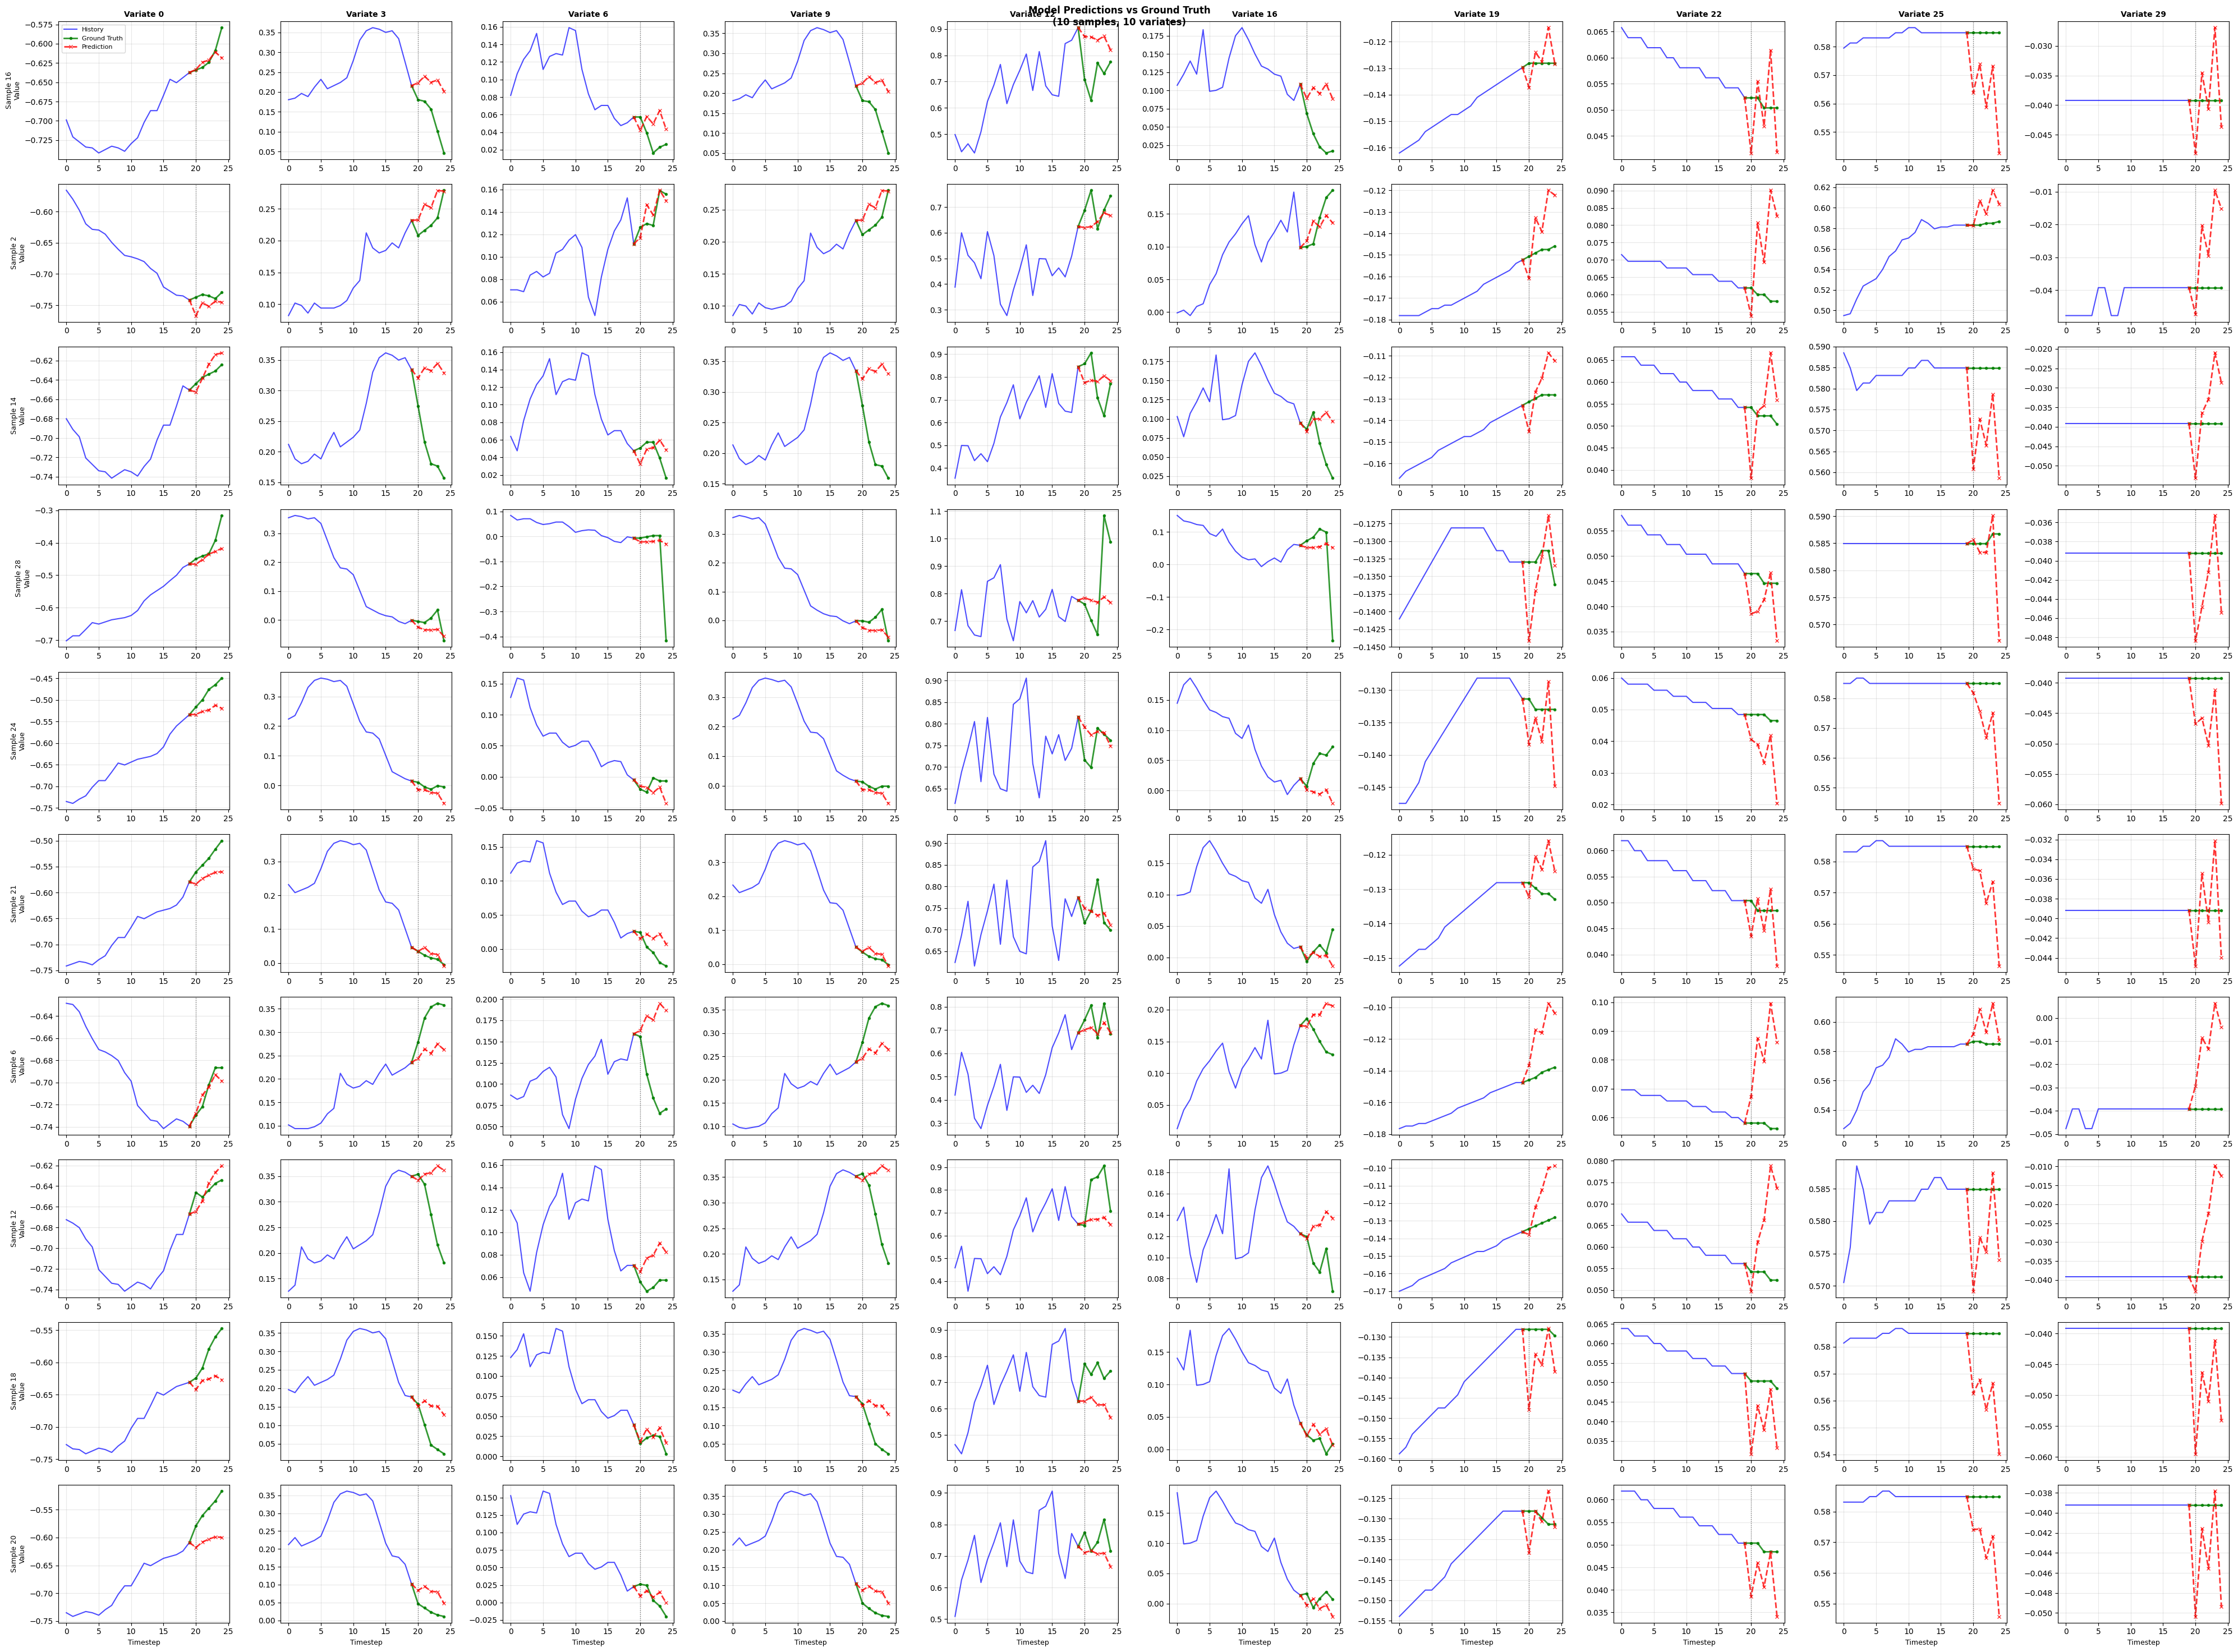

In [7]:
visualize_predictions(
    model=model,
    data_loader=test_loader,
    device='cpu',
    num_samples=10,
    num_variates=10,
    save_path=None
)


SUMMARY OF 1 EXPERIMENTS from all_experiments.json

--- Experiment 1: test_small_cpu ---
  Timestamp:     20251204_012338
  Final MSE:     0.053545
  Final MAE:     0.074478
  Best MSE:      0.053545 (epoch 2)
  Best MAE:      0.074478
  Parameters:    584,047


EXPERIMENT SUMMARY: test_small_cpu

Timestamp:     20251204_012338
Model File:    model_test_small_cpu_20251204_012338.pth

Training Config:
  num_epochs          : 2
  learning_rate       : 0.001
  weight_decay        : 0.001
  use_scheduler       : True
  scheduler_factor    : 0.5
  scheduler_patience  : 1
  batch_size          : 32

Model Info:
  Total Parameters:      584,047
  Trainable Parameters:  584,047

Final Metrics:
  Train Loss (MSE):  0.098756
  Test Loss (MSE):   0.053545
  Test MAE:          0.074478

Best Metrics:
  Best Test Loss:    0.053545 (epoch 2)
  Best Test MAE:     0.074478



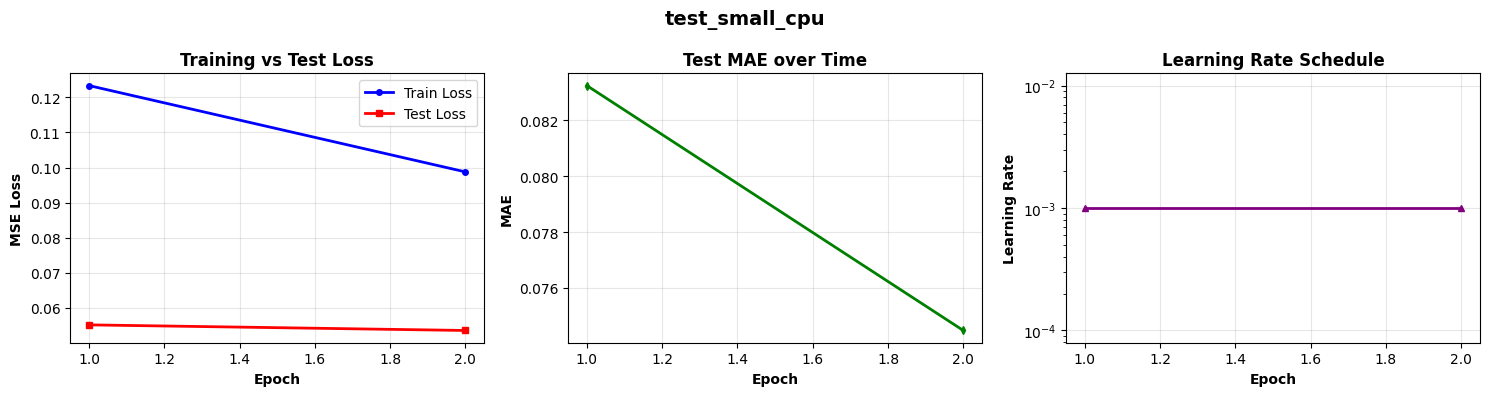

In [3]:
# Print all experiments in file
print_experiment_summary('all_experiments.json')

# Print specific experiment
print_experiment_summary('all_experiments.json', experiment_name='test_small_cpu')

# Plot specific experiment
plot_training_history('all_experiments.json', experiment_name='test_small_cpu')

# Plot most recent experiment (no name provided)
#plot_training_history('all_experiments.json')

# Compare specific experiments
#compare_experiments('all_experiments.json', experiment_names=['baseline_v1', 'with_skip']) # no exeriment_name -> all experiments